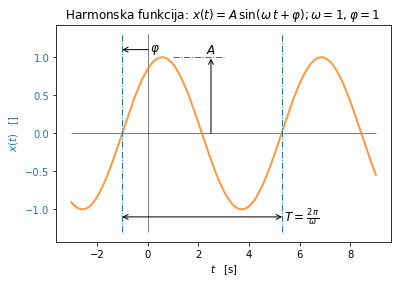

In [1]:
import numpy as np
import matplotlib.pyplot as plt


T = 6
A = 1
t, dt = np.linspace(-0.5*T,1.5*T,201, retstep=True)
ω = 1
ϕ = 1

fig, ax1 = plt.subplots()
plt.title(f'Harmonska funkcija: $x(t) = A\,\sin(\\omega\,t+\\varphi); \\omega={ω}, \\varphi={ϕ}$ ')

ax1.set_xlabel('$t\\quad $[s]')
ax1.set_ylabel('$x(t)\quad$[]', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax1.vlines(0, -1.3, 1.3, 'k', lw=0.5)
ax1.hlines(0, np.min(t), np.max(t), 'k', lw=0.5)
ax1.plot(t, A*np.sin(ω*t+ϕ), label='Harmonski podatki', c='C1', lw=2, alpha=0.8) 
ax1.vlines(-ϕ+2*np.pi*np.arange(T/(ω*2*np.pi)+1), -1.3, 1.3, ls='-.', lw=1)
ax1.annotate('$\\varphi$',
            xy=(-ϕ, 1.1), xycoords='data',
            va='center', size='large',
            xytext=(0.1, 1.1), textcoords='data',
            arrowprops=dict(arrowstyle='->',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
ax1.hlines(A, 1., 3, ls='-.', lw=1)
ax1.annotate('$A$',
            xy=(2.5, 0), xycoords='data',
            ha='center', size='large',
            xytext=(2.5, A+.05), textcoords='data',
            arrowprops=dict(arrowstyle='<-',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
ax1.annotate('$T=\\frac{2\,\pi}{\\omega}$',
            xy=(-ϕ, -1.1), xycoords='data',
            va='center', size='large', 
            xytext=(2*np.pi-ϕ+0.1, -1.1), textcoords='data',
            arrowprops=dict(arrowstyle='<->',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
plt.show()

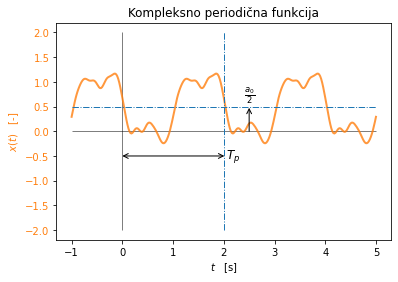

In [5]:
import numpy as np
import matplotlib.pyplot as plt


Tp = 2
t, dt = np.linspace(-0.5*Tp,2.5*Tp,301, retstep=True)
a0 = 1.
N = 10
seed = 0
rg = np.random.default_rng(seed)
a = rg.normal(size=N)*1/np.arange(1,N+1)**2 #skaliranje na koncu, da imajo višje komponente imajo manjšo amplitudo
b = rg.normal(size=N)*1/np.arange(1,N+1)**2
x = a0/2
for n in range(N):
    x += a[n]*np.cos(2*np.pi*(n+1)*t/Tp) + b[n]*np.sin(2*np.pi*(n+1)*t/Tp)

fig, ax1 = plt.subplots()
plt.title(f'Kompleksno periodična funkcija')

ax1.set_xlabel('$t\\quad $[s]')
ax1.set_ylabel('$x(t)\quad$[-]', color='C1')
ax1.tick_params(axis='y', labelcolor='C1')
ax1.vlines(0, -2, 2, 'k', lw=0.5)
ax1.hlines(0, np.min(t), np.max(t), 'k', lw=0.5)
ax1.plot(t, x, label='Periodični podatki', c='C1', lw=2, alpha=0.8) 
ax1.vlines([Tp], -2, 2, ls='-.', lw=1)
ax1.hlines(a0/2, np.min(t), np.max(t), ls='-.', lw=1)
ax1.annotate('$\\frac{a_0}{2}$',
            xy=(2.5, 0), xycoords='data',
            ha='center', size='large',
            xytext=(2.5, a0/2+.15), textcoords='data',
            arrowprops=dict(arrowstyle='<-',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
ax1.annotate('$T_{p}$',
            xy=(0, -0.5), xycoords='data',
            va='center', size='large', 
            xytext=(Tp+0.05, -0.5), textcoords='data',
            arrowprops=dict(arrowstyle='<->',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
#plt.ylim(-1,2)
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt


Tp = 2
t, dt = np.linspace(-0.5*Tp,2.5*Tp,301, retstep=True)
a0 = 1.
N = 10
seed = 0
rg = np.random.default_rng(seed)
a = rg.normal(size=N)*1/np.arange(1,N+1)**2 #skaliranje na koncu, da imajo višje komponente imajo manjšo amplitudo
b = rg.normal(size=N)*1/np.arange(1,N+1)**2

In [8]:
a

array([ 0.12573022, -0.03302622,  0.07115807,  0.00655626, -0.02142677,
        0.01004431,  0.02661225,  0.01479814, -0.00868809, -0.01265421])

In [9]:
b

array([-0.62327446,  0.01033149, -0.25833675, -0.01367448, -0.04983644,
       -0.02034076, -0.01110733, -0.00494219,  0.00508186,  0.01042513])

In [10]:
c = np.zeros(2*N+1, dtype='complex')
c[N+1:] = 0.5*a-0.5j*b
c[N] = a0/2
c[:N] = np.conj(c[N+1:])[::-1]

In [11]:
c

array([-0.00632711+0.00521257j, -0.00434404+0.00254093j,
        0.00739907-0.00247109j,  0.01330612-0.00555366j,
        0.00502215-0.01017038j, -0.01071339-0.02491822j,
        0.00327813-0.00683724j,  0.03557904-0.12916838j,
       -0.01651311+0.00516575j,  0.06286511-0.31163723j,
        0.5       +0.j        ,  0.06286511+0.31163723j,
       -0.01651311-0.00516575j,  0.03557904+0.12916838j,
        0.00327813+0.00683724j, -0.01071339+0.02491822j,
        0.00502215+0.01017038j,  0.01330612+0.00555366j,
        0.00739907+0.00247109j, -0.00434404-0.00254093j,
       -0.00632711-0.00521257j])

In [21]:
x1 = a0/2
for n in range(N):
    x1 += a[n]*np.cos(2*np.pi*(n+1)*t/Tp) + b[n]*np.sin(2*np.pi*(n+1)*t/Tp)

x = np.zeros(len(t), 'complex')
for n in range(-N,N+1):
    x += c[N+n]*np.exp(2j*np.pi*n*t/Tp)

In [22]:
x1[:10]

array([0.2923326 , 0.39301093, 0.49253799, 0.5867607 , 0.67258178,
       0.74853348, 0.81478531, 0.87257884, 0.92332026, 0.96771094])

In [24]:
x = np.real(x)
x[:10]

array([0.2923326 , 0.39301093, 0.49253799, 0.5867607 , 0.67258178,
       0.74853348, 0.81478531, 0.87257884, 0.92332026, 0.96771094])

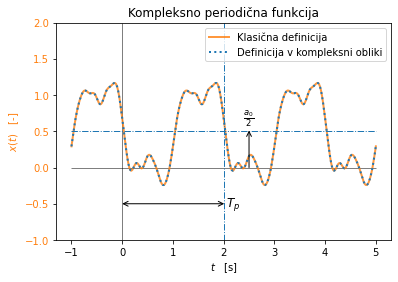

In [25]:
fig, ax1 = plt.subplots()
plt.title(f'Kompleksno periodična funkcija')

ax1.set_xlabel('$t\\quad $[s]')
ax1.set_ylabel('$x(t)\quad$[-]', color='C1')
ax1.tick_params(axis='y', labelcolor='C1')
ax1.vlines(0, -2, 2, 'k', lw=0.5)
ax1.hlines(0, np.min(t), np.max(t), 'k', lw=0.5)
ax1.plot(t, x1, label='Klasična definicija', c='C1', lw=2, alpha=0.8) 
ax1.plot(t, x, label='Definicija v kompleksni obliki', c='C0', ls=':', lw=2, alpha=1) 
ax1.vlines([Tp], -2, 2, ls='-.', lw=1)
ax1.hlines(a0/2, np.min(t), np.max(t), ls='-.', lw=1)
ax1.annotate('$\\frac{a_0}{2}$',
            xy=(2.5, 0), xycoords='data',
            ha='center', size='large',
            xytext=(2.5, a0/2+.13), textcoords='data',
            arrowprops=dict(arrowstyle='<-',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
ax1.annotate('$T_{p}$',
            xy=(0, -0.5), xycoords='data',
            va='center', size='large', 
            xytext=(Tp+0.05, -0.5), textcoords='data',
            arrowprops=dict(arrowstyle='<->',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
ax1.legend(loc=1)
plt.ylim(-1,2)
plt.show()